# Regressão Linear - Box-Cox + Transformação de Variáveis
 Legendas:
   * <code style="color:green">Explicação Conteúdo</code>
   * <code style="color:purple">Dicas / Comandos / Comentários</code>
   * <code style="color:red">Prática</code>



In [1]:
import pandas as pd # importando a biblioteca de manipulação de dados
import statsmodels.api as sm # biblioteca para a regressão logística
import numpy as np # biblioteca para calculo
from matplotlib import pyplot as plt # importando a biblioteca de visualização de dados 
import seaborn as sns# importando a biblioteca de visualização de dados 
from sklearn.metrics import mean_squared_error
import scipy.stats as stats # biblioteca para análise estatistica
from statsmodels.stats.diagnostic import het_breuschpagan # função para o teste de breusch-pagan
import pyreadr # biblioteca para leitura de dados R
import numpy as np # biblioteca para calculo numérico
from statsmodels.graphics.factorplots import interaction_plot # gráfico de interação
from sklearn.preprocessing import PowerTransformer # função para a transformação boxcox

C:\Users\mattr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\__init__.py:169: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### <code style="color:green">DISCUSSÃO:</code>

No python, utilizando as bibliotecas mais conhecidas, não encontramos os métodos de seleção backward, forward e setpwise. Logo, a solução para quando se quer utilizá-los é criar alguma função que o faça. 

Sendo assim, criamos algumas funções que serão utilizadas em aula para seleção de variáveis. Elas serão carregadas todas de uma única vez:

In [2]:
from selecao_variaveis_regressao_linear import step

### <code style="color:green">Vamos começar:</code>

- O propósito aqui é utilizar a base preços, selecionar apenas as variáveis numéricas e tentar aplicar a transformação BoxCox a fim de verificar se o modelo melhora (não quer dizer que vai melhorar).
- Além disso testaremos o BoxCox com as variáveis X transformadas.

In [3]:
# fazendo a leitura do arquivo já em R (caso não tenha essa biblioteca, não deixe de instalar)
precos = pyreadr.read_r('dados/precos.rds')[None]
precos

,SalePrice,Basement_Area,Lot_Area,Heating_QC,Season_Sold,Gr_Liv_Area,Garage_Area,Deck_Porch_Area,Age_Sold,Bedroom_AbvGr,Total_Bathroom
0,215000.0,1080.0,31770.0,Fa,2.0,1656.0,528.0,272.0,50.0,3.0,2.0
1,105000.0,882.0,11622.0,TA,3.0,896.0,730.0,260.0,49.0,2.0,1.0
2,172000.0,1329.0,14267.0,TA,3.0,1329.0,312.0,429.0,52.0,3.0,1.1
3,244000.0,2110.0,11160.0,Ex,2.0,2110.0,522.0,0.0,42.0,3.0,3.1
4,189900.0,928.0,13830.0,Gd,2.0,1629.0,482.0,246.0,13.0,3.0,2.1
...,...,...,...,...,...,...,...,...,...,...,...
2923,142500.0,1003.0,7937.0,TA,2.0,1003.0,588.0,120.0,22.0,3.0,2.0
2924,131000.0,864.0,8885.0,TA,3.0,902.0,484.0,164.0,23.0,2.0,2.0
2925,132000.0,912.0,10441.0,TA,3.0,970.0,0.0,112.0,14.0,3.0,1.1
2926,170000.0,1389.0,10010.0,Gd,2.0,1389.0,418.0,278.0,32.0,2.0,2.0


In [4]:
# selecionando apenas as variaveis numericas para brincar
precos = precos.drop(['Heating_QC','Season_Sold'],axis = 1)

### <code style="color:green">Modelo sem nenhuma transformação:</code>

In [5]:
# criando o modelo com todas as X´s sem transformação alguma
# Criando o objeto X com a variável independentes. 
X = precos.drop(['SalePrice'],axis = 1)
# criando o objeto y com a variável resposta
y = precos["SalePrice"]
# Aqui lembre-se do B0. Basicamente vamos adicionar uma coluna de 1s para que o B0 seja calculado.
X = sm.add_constant(X)
# Ajustando o modelo
model_preco_original_completo = sm.OLS(y, X).fit()
# Resumo do modelo
print(model_preco_original_completo.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.755
Model:                            OLS   Adj. R-squared:                  0.754
Method:                 Least Squares   F-statistic:                     1122.
Date:                Tue, 21 Jan 2025   Prob (F-statistic):               0.00
Time:                        14:07:03   Log-Likelihood:                -35149.
No. Observations:                2928   AIC:                         7.032e+04
Df Residuals:                    2919   BIC:                         7.037e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             3.68e+04   4070.624     

### <code style="color:green">Gráfico Resíduos do modelo sem nenhuma transformação:</code>

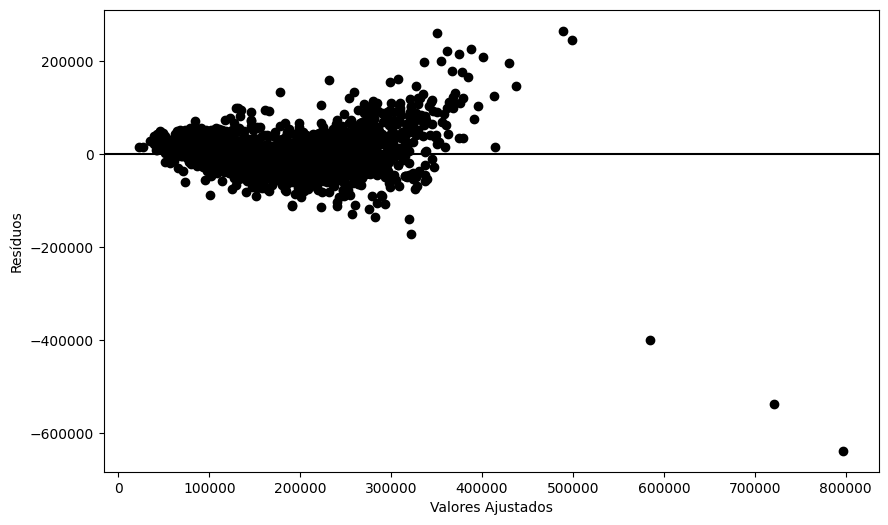

In [6]:
# plotando o ajustado X residuo 
plt.figure(figsize=(10, 6))
#fazendo o gráfico de predito x resíduo
plt.scatter(model_preco_original_completo.predict(X),model_preco_original_completo.resid, color='black')
plt.axhline(y=0, color = 'black')
plt.xlabel('Valores Ajustados')
plt.ylabel('Resíduos')
plt.show()

### <code style="color:green">Relembrando Transformação Box-Cox</code>

Para realizar a transformação Box-Cox primeiro precisamos do valor do $\lambda$:

$$
y(\lambda) = 
\begin{cases} 
\frac{y^\lambda - 1}{\lambda} & \text{se } \lambda \neq 0 \\
\log(y) & \text{se } \lambda = 0
\end{cases} 
$$

In [7]:
#descobrinado lambda

# criando o objeto para transformar
pt = PowerTransformer('box-cox') 

# ajustando aos dados
power = pt.fit_transform(precos[['SalePrice']]) 
# retirando o lambda
lambda_param = pt.lambdas_ 
print(lambda_param)

[0.00766592]


### <code style="color:green">Transformando o Y</code>

Com o $\lambda$ gerado, agora podemos transformar a variável y (note que a variável `power` já é os y transformados mas vamos criar a fórmula do zero)!

In [8]:
precos['BC_SalePrice'] = ((precos['SalePrice']**lambda_param[0]) -1)/ lambda_param[0]
precos['BC_SalePrice']

0       12.874811
1       12.089558
2       12.629854
3       13.013897
4       12.738483
          ...    
2923    12.423633
2924    12.331504
2925    12.339828
2926    12.617026
2927    12.727446
Name: BC_SalePrice, Length: 2928, dtype: float64

### <code style="color:green">Modelo Box-Cox sem nenhuma transformação nos X´s:</code>

In [9]:
# criando o modelo com todas as X´s sem transformação alguma porem com Y do BoxCox
# Criando o objeto X com a variável independentes. 
X = precos.drop(['SalePrice','BC_SalePrice'],axis = 1)
# criando o objeto y com a variável resposta transformada
y = precos["BC_SalePrice"]
# Aqui lembre-se do B0. Basicamente vamos adicionar uma coluna de 1s para que o B0 seja calculado.
X = sm.add_constant(X)
# Ajustando o modelo
model_BC_preco_original_completo = sm.OLS(y, X).fit()
# Resumo do modelo
print(model_BC_preco_original_completo.summary())

                            OLS Regression Results                            
Dep. Variable:           BC_SalePrice   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     1245.
Date:                Tue, 21 Jan 2025   Prob (F-statistic):               0.00
Time:                        14:07:03   Log-Likelihood:                 377.30
No. Observations:                2928   AIC:                            -736.6
Df Residuals:                    2919   BIC:                            -682.8
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              11.8005      0.022    5

### <code style="color:green">Gráfico Resíduos do modelo com y transformado BoxCox e as X´s sem nenhuma transformação:</code>

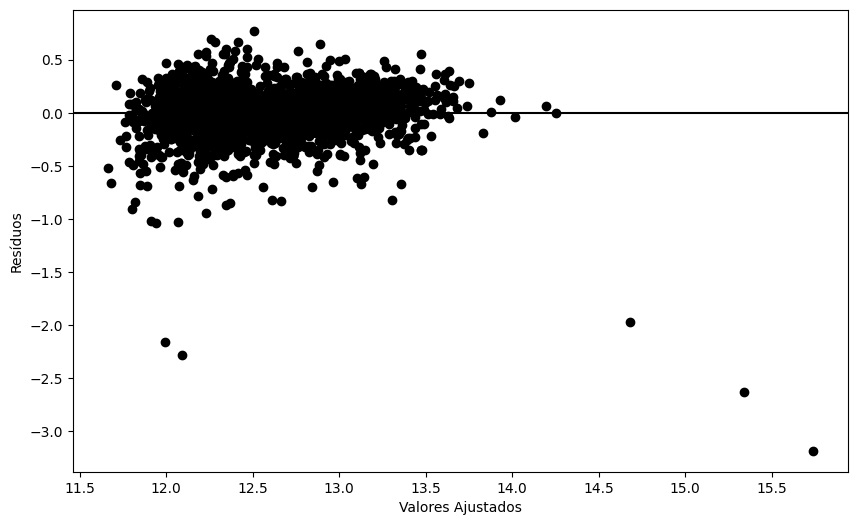

In [10]:
# plotando o ajustado X residuo 
plt.figure(figsize=(10, 6))
#fazendo o gráfico de predito x resíduo
plt.scatter(model_BC_preco_original_completo.predict(X),model_BC_preco_original_completo.resid, color='black')
plt.axhline(y=0, color = 'black')
plt.xlabel('Valores Ajustados')
plt.ylabel('Resíduos')
plt.show()

### <code style="color:purple">COMENTÁRIOS:</code>

- Ainda não resolvemos o problema, mas já pudemos ver o efeito. Notou que o desenho de buumerang já suavizou?

- Quem sabe transformando as X´s a gente resolva o problema. Vamos testar?

### <code style="color:green">Transformando as Variáveis X´s</code>

- Quando temos as variáveis independentes muito assimétricas, uma boa estratégia é realizar a transformação em LOG delas!

- Assim elas podem ajudar não só no desempenho do modelo, mas também ajudam a normalizar os resíduos

In [11]:
# primeiro vou aplicar o log de todas as variaveis X´s
precos_log = precos.copy()
precos_log['Basement_Area_log'] = np.log10(precos_log['Basement_Area'] + 1)
precos_log['Lot_Area_log'] = np.log10(precos_log['Lot_Area'] + 1)
precos_log['Gr_Liv_Area_log'] = np.log10(precos_log['Gr_Liv_Area'] + 1)
precos_log['Garage_Area_log'] = np.log10(precos_log['Garage_Area'] + 1)
precos_log['Deck_Porch_Area_log'] = np.log10(precos_log['Deck_Porch_Area'] + 1)
precos_log['Age_Sold_log'] = np.log10(precos_log['Age_Sold'] + 2)
precos_log['Bedroom_AbvGr_log'] = np.log10(precos_log['Bedroom_AbvGr'] + 1)
precos_log['Total_Bathroom_log'] = np.log10(precos_log['Total_Bathroom'] + 1)

### <code style="color:green">Transformando o Y na base com X em log</code>

Com o $\lambda$ gerado, agora podemos transformar a variável y (note que a variável `power` já é os y transformados mas vamos criar a fórmula do zero)!

In [12]:
precos_log['BC_SalePrice'] = ((precos_log['SalePrice']**lambda_param[0]) -1)/ lambda_param[0]
precos_log['BC_SalePrice']

0       12.874811
1       12.089558
2       12.629854
3       13.013897
4       12.738483
          ...    
2923    12.423633
2924    12.331504
2925    12.339828
2926    12.617026
2927    12.727446
Name: BC_SalePrice, Length: 2928, dtype: float64

### <code style="color:green">Modelo Box-Cox com transformação nos X´s:</code>

In [13]:
# criando o modelo com todas as X´s com transformação log e com Y do BoxCox
# Criando o objeto X com a variável independentes. 
X = precos_log.filter(like='_log')
# criando o objeto y com a variável resposta transformada
y = precos_log["BC_SalePrice"]
# Aqui lembre-se do B0. Basicamente vamos adicionar uma coluna de 1s para que o B0 seja calculado.
X = sm.add_constant(X)
# Ajustando o modelo
model_BC_preco_trans_completo = sm.OLS(y, X).fit()
# Resumo do modelo
print(model_BC_preco_trans_completo.summary())

                            OLS Regression Results                            
Dep. Variable:           BC_SalePrice   R-squared:                       0.794
Model:                            OLS   Adj. R-squared:                  0.793
Method:                 Least Squares   F-statistic:                     1403.
Date:                Tue, 21 Jan 2025   Prob (F-statistic):               0.00
Time:                        14:07:04   Log-Likelihood:                 514.95
No. Observations:                2928   AIC:                            -1012.
Df Residuals:                    2919   BIC:                            -958.1
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   6.5942    

### <code style="color:green">Gráfico Resíduos do modelo com y transformado BoxCox e as X´s com transformação log:</code>

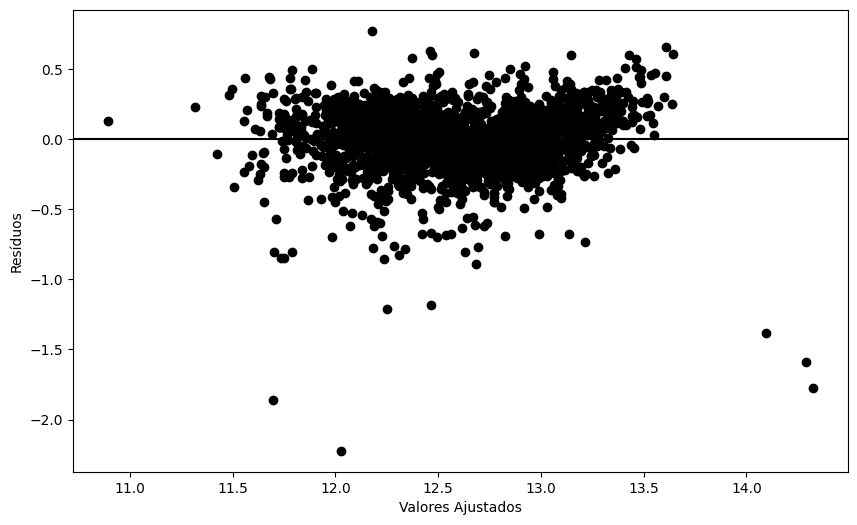

In [14]:
# plotando o ajustado X residuo 
plt.figure(figsize=(10, 6))
#fazendo o gráfico de predito x resíduo
plt.scatter(model_BC_preco_trans_completo.predict(X),model_BC_preco_trans_completo.resid, color='black')
plt.axhline(y=0, color = 'black')
plt.xlabel('Valores Ajustados')
plt.ylabel('Resíduos')
plt.show()

### <code style="color:purple">COMENTÁRIOS:</code>

- Infelizmente não resolvemos o problema, eventualmente esse problema não consegue ser resolvido com Regressão Linear =/

Vamos entender o predict quando usamos a transformação BoxCox?

Quero que você observe o y verdadeiro, o y transformado e o ychapeu do ytransformado

In [15]:
precos_log['ychapeu_transformado'] = model_BC_preco_trans_completo.predict(X)
precos_log[['SalePrice', 'BC_SalePrice', 'ychapeu_transformado']].head()

,SalePrice,BC_SalePrice,ychapeu_transformado
0,215000.0,12.874811,12.796653
1,105000.0,12.089558,12.250939
2,172000.0,12.629854,12.468587
3,244000.0,13.013897,12.872005
4,189900.0,12.738483,12.828325


### <code style="color:purple">COMENTÁRIOS:</code>

Você notou que o modelo prediz o valor transformado?

Sendo assim, do que adianta, não é mesmo? O que faríamos com isso na vida prática?

Nada, não é mesmo?

Mas é exatamente isso que o artigo do Box e Cox nos ajuda. Eles demonstram que para que o ychapeu_transformado seja o ychapeu original precisamos aplicar a seguinte transformação:

$$\left( \left( BCy \cdot \lambda \right) + 1 \right) ^ \left( \frac{1}{\lambda} \right)$$



In [16]:
# formula: (((BC_y * lambda) + 1)) ^ (1 / lambda)
# ou seja, vou retrasnformar o ychapeu_transformado para o ychapeu original
precos_log['ychapeu'] = ((precos_log['ychapeu_transformado'] * lambda_param[0]) +1) ** (1/lambda_param[0])
# limitando o valor de ychapeu a duas casas decimais
precos_log['ychapeu'] = precos_log['ychapeu'].round(2)
# mostrando as variáveis que me importam
precos_log[['SalePrice', 'BC_SalePrice', 'ychapeu_transformado' , 'ychapeu']].head()

,SalePrice,BC_SalePrice,ychapeu_transformado,ychapeu
0,215000.0,12.874811,12.796653,200233.01
1,105000.0,12.089558,12.250939,121701.23
2,172000.0,12.629854,12.468587,148469.64
3,244000.0,13.013897,12.872005,214451.49
4,189900.0,12.738483,12.828325,206091.64
